In [37]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from step import preprocessing as pp

import math
import pandas as pnd
import numpy as np
import gpxpy
import folium
from rdflib import URIRef, Namespace, Graph
import shapely
from shapely import wkt
from shapely.ops import polygonize_full, cascaded_union
import geojson
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib notebook

matplotlib.rcParams['axes.labelsize'] = 'large'
matplotlib.rcParams['ytick.labelsize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 'medium'
matplotlib.rcParams['figure.figsize'] = (9, 6)
sns.set_style('ticks', {"axes.xmargin": 0.2, "axes.ymargin": 0.2});

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
file_path = r'gpx\41837719-1331819793.gpx'
gpx = gpxpy.parse(open(file_path, 'r'))

#Ignore first 30 seconds (to avoid GPS "time to first fix")
gpx = pp.discard(gpx, timedelta(seconds=30))

movement_attributes = pp.get_movement_attributes(gpx)
df_all = pnd.DataFrame(movement_attributes, index=movement_attributes['timestamp'])

df = df_all[1:]

i_series = pnd.Series(np.arange(len(df)), index=df.index).rename('idx')
df = pnd.concat([df, i_series], axis=1)

df.head(5)

,acceleration,angle,distance,duration,elevation,heading,latitude,longitude,speed,timestamp,idx
2016-02-02 09:00:49,0.03,171.46,10.80,5,217,65,45.186855,5.738789,2.16,2016-02-02 09:00:49,0
2016-02-02 09:00:54,-0.11,104.36,11.61,5,217,56,45.186914,5.738911,2.32,2016-02-02 09:00:54,1
2016-02-02 09:01:05,0.37,158.09,11.99,11,218,340,45.187015,5.738860,1.09,2016-02-02 09:01:05,2
2016-02-02 09:01:09,-0.14,156.81,10.29,4,218,318,45.187085,5.738773,2.57,2016-02-02 09:01:09,3
2016-02-02 09:01:15,-0.06,158.54,10.24,6,218,295,45.187124,5.738655,1.71,2016-02-02 09:01:15,4


In [39]:
points_data = gpx.get_points_data()
points = [(pdata.point.latitude, pdata.point.longitude) for pdata in points_data]

In [40]:
tileset = r'http://{s}.tile.openstreetmap.se/hydda/full/{z}/{x}/{y}.png'
attribution = 'Tiles courtesy of <a href="http://openstreetmap.se/" target="_blank">OpenStreetMap Sweden</a> \
                &mdash; Map data &copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>'

_map = folium.Map(tiles=tileset, attr=attribution, max_zoom=25)

start_mark = folium.Marker([points[0][0], points[0][1]], icon=folium.Icon(color='green', icon='glyphicon glyphicon-play'))
start_mark.add_to(_map)

end_mark = folium.Marker([points[-1][0], points[-1][1]], icon=folium.Icon(color='red', icon='glyphicon glyphicon-stop'))
end_mark.add_to(_map)

line = folium.PolyLine(points, opacity=0.8)
line.add_to(_map)
_map.fit_bounds(line.get_bounds())

_map

## Space-time cube

<IPython.core.display.Javascript object>


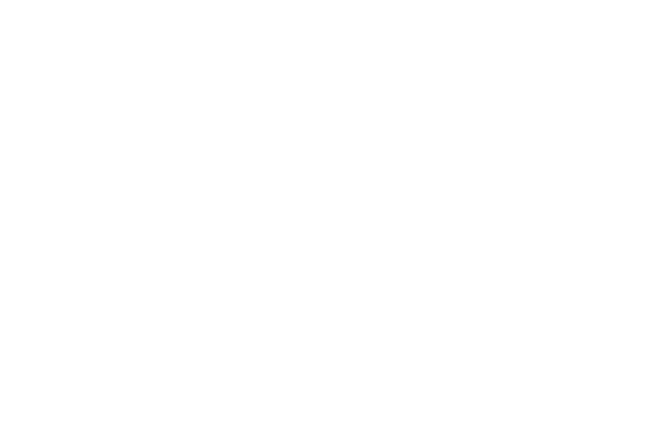

<IPython.core.display.Javascript object>


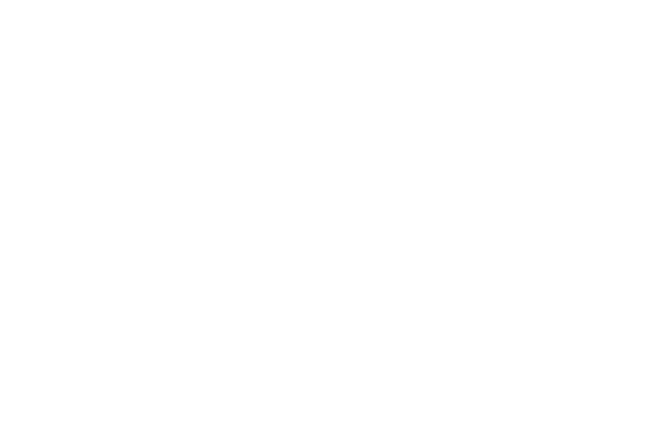

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.longitude, df.latitude, zs=0, c='gainsboro', depthshade=True, linewidth=0)
seconds = df['timestamp'].dt.second.cumsum()
#ax.plot(df.longitude, df.latitude, seconds, 'o:', ms=5);
scatter = ax.scatter(df.longitude, df.latitude, seconds, c=df.speed, depthshade=True, cmap=cm.hot, 
                     edgecolors='face', label='speed');

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('time')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

central_latitude = sum(ax.get_ylim())/2.
mercator_aspect_ratio = 1/math.cos(math.radians(central_latitude))
ax.set_aspect(mercator_aspect_ratio, adjustable='datalim')

fig.colorbar(scatter, label='speed (m/s)', pad=.1, shrink=.7)
plt.tight_layout()

In [6]:
matplotlib.__version__

'1.5.3'